In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet")

In [3]:
df = df[df['id_no2'] == '28079035']

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math

# 2. Split temporal
def split_data(df, split_date='2024-01-01'):
    df['fecha'] = pd.to_datetime(df['fecha'])
    return df[df['fecha'] < split_date], df[df['fecha'] >= split_date]

# 3. Calcular anomalías
def add_anomalies(train, test, cols):
    for col in cols:
        mean = train[col].mean()
        train[f'{col}_anom'] = train[col] - mean
        test[f'{col}_anom'] = test[col] - mean
    return train, test

# 4. Escalado
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test), scaler

def plot_effects_grid_pretty(gam, features, scaler, cols=2):
    """
    Muestra los efectos parciales en unidades originales.
    `scaler` es el StandardScaler ajustado a X_train.
    """
    import math, matplotlib.pyplot as plt

    rows = math.ceil(len(features) / cols)
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols*5.5, rows*3.2),
                             constrained_layout=True)
    axes = axes.flatten()

    for i, feat in enumerate(features):
        XX = gam.generate_X_grid(term=i)          # grid en espacio escalado
        # ← des-escalado: x_original = x_std * σ + μ
        mu   = scaler.mean_[i]
        sigma = np.sqrt(scaler.var_[i])
        x_orig = XX[:, i] * sigma + mu

        ax = axes[i]
        ax.plot(x_orig,
                gam.partial_dependence(term=i, X=XX),
                lw=1.8, color='black')
        ax.set_title(feat, fontsize=11)
        ax.set_xlabel(feat,  fontsize=9)
        ax.set_ylabel('Efecto parcial (µg m⁻³)', fontsize=9)
        ax.axhline(0, ls='--', lw=0.6, color='grey')
        ax.grid(alpha=.3)

    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    ax.axhline(0, ls='--', lw=.6, color='grey', alpha=.5)
    #ax.set_title(label_map.get(feat, feat), fontsize=10)
    ax.tick_params(labelsize=8)

    fig.suptitle('Efectos Parciales del GAM', fontsize=14, y=1.02)
    plt.show()



def create_cyclical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Crea variables cíclicas para capturar patrones temporales."""
    df = df.copy()

    # Crear variables temporales base
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['day_of_year'] = df['fecha'].dt.dayofyear
    df['month'] = df['fecha'].dt.month
    df['year'] = df['fecha'].dt.year
    df['weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['hour'] = df['fecha'].dt.hour
    df['day'] = df['fecha'].dt.day
    
    # Crear variable estacional numérica (0-3: winter, spring, summer, autumn)
    df['season'] = df['month'].apply(
        lambda x: 0 if x in [12,1,2] else 1 if x in [3,4,5] else 2 if x in [6,7,8] else 3
    )
    
    # Variables cíclicas temporales básicas
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Variables cíclicas adicionales más específicas
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
    df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
        
    return df

In [5]:
# === MAIN ===
df = create_cyclical_features(df)
train, test = split_data(df)

# Crear anomalías
train, test = add_anomalies(train, test, ['sp'])
train['ssr_sum24_c'] = train['ssr_sum24'] - train['ssr_sum24'].mean()
test['ssr_sum24_c']  = test['ssr_sum24']  - train['ssr_sum24'].mean()

# Lista final de features
features = [
    'intensidad_lag8',
    't2m_ma6',
    'd2m_ma6',
    'sp_ma6',                 # usará la anomalía si renombraste
    'wind_speed_ma24',
    'wind_dir_sin_ma6',
    'tp_sum24',
    'ssr_sum24',
    'hour_sin',
    'hour_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'season_sin',
    'season_cos',
    'weekend'  # tratada como categórica
]

X_train = train[features]
X_test = test[features]
y_train = train['no2_value']
y_test = test['no2_value']

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_34927/2484384137.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'{col}_anom'] = train[col] - mean
/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_34927/2484384137.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'{col}_anom'] = test[col] - mean
/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_34927/3140897967.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [12]:
print(len(features))

15


In [13]:
# Escalado
X_train_s, X_test_s, scaler = scale_features(X_train, X_test)

from functools import reduce
from operator import add

terms = [
    s(0, n_splines=12, lam=10),      # intensidad_lag8
    s(1, n_splines=15, lam=20),      # t2m_ma6
    s(2, n_splines=15, lam=20),      # d2m_ma6
    s(3, n_splines=12, lam=20),      # sp_ma6
    s(4, n_splines=12, lam=20),      # wind_speed_ma24
    s(5, n_splines=8,  lam=30),      # SOLO wind_dir_sin_ma6 (cos fuera)
    s(6, n_splines=12, lam=30),      # tp_sum24_log  (np.log1p)
    s(7, n_splines=12, lam=30),      # ssr_sum24_c
    s(8) + s(9),                    # hour sin+cos
    s(10) + s(11),                   # day-of-week sin+cos
    f(12),                           # estación (categoría 4 valores)
    f(13)                            # weekend (0/1)
]
gam = LinearGAM(reduce(add, terms)).gridsearch(X_train_s, y_train)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:07 ETA:   0:01:19
 18% (2 of 11) |####                     | Elapsed Time: 0:00:18 ETA:   0:01:22
 27% (3 of 11) |######                   | Elapsed Time: 0:00:28 ETA:   0:01:15
 36% (4 of 11) |#########                | Elapsed Time: 0:00:38 ETA:   0:01:07
 45% (5 of 11) |###########              | Elapsed Time: 0:00:48 ETA:   0:00:57
 54% (6 of 11) |#############            | Elapsed Time: 0:00:55 ETA:   0:00:46
 63% (7 of 11) |###############          | Elapsed Time: 0:01:00 ETA:   0:00:34
 72% (8 of 11) |##################       | Elapsed Time: 0:01:04 ETA:   0:00:24
 81% (9 of 11) |####################     | Elapsed Time: 0:01:08 ETA:   0:00:15
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:13 ETA:   0:00:07
100% (11 of 11) |########################| Elapsed Time: 0:01:18 Time:  0:01:18


In [8]:
gam = LinearGAM(reduce(add, terms)).fit(X_train_s, y_train)

ValueError: cannot create grid for intercept term

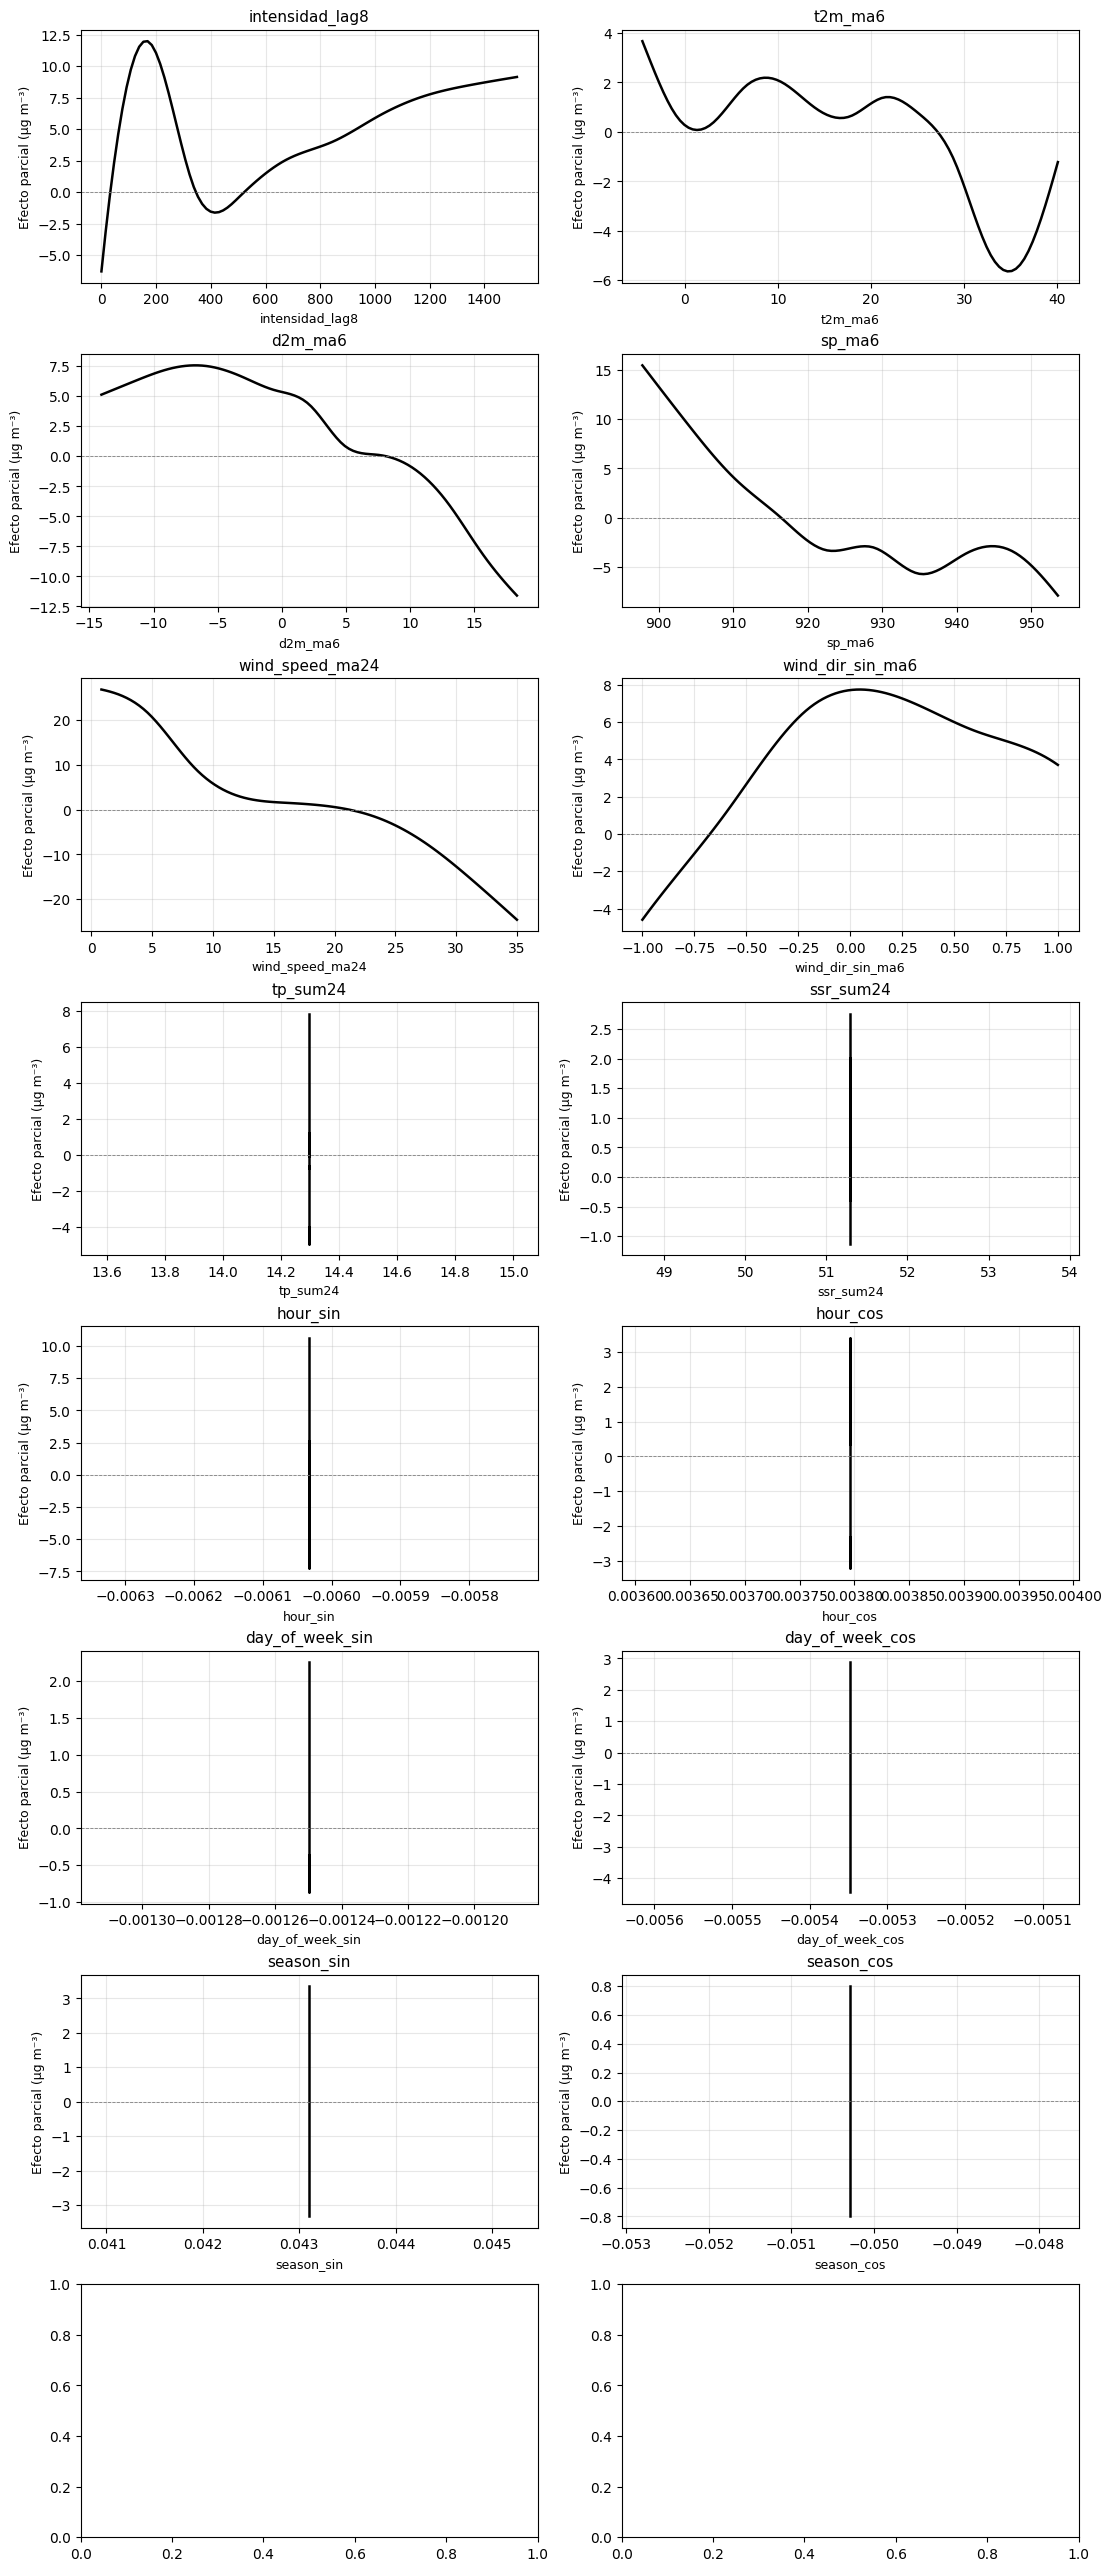

In [9]:
plot_effects_grid_pretty(gam, features, scaler, cols=2)


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predecir sobre el test set
y_pred = gam.predict(X_test_s)

# Calcular RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE en test: {rmse:.2f} µg/m³')

RMSE en test: 14.87 µg/m³


In [ ]:
y_pred = gam.predict(X_test_s)
rmse    = mean_squared_error(y_test, y_pred, squared=False)
r2      = gam.score(X_test_s, y_test)
print(f'RMSE test = {rmse:.1f} µg m⁻³   |   R² = {r2:.3f}')


TypeError: got an unexpected keyword argument 'squared'